# Feature Selection
Select the most relevant features for predicting success using statistical methods and feature importance techniques. This step helps reduce dimensionality and focus on the most predictive variables.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
# The 'seaborn-whitegrid' style is deprecated in newer versions of matplotlib
# Using a currently supported style instead
try:
    # First try the new style naming convention
    plt.style.use('seaborn-v0_8-whitegrid')  # For newer matplotlib versions
except:
    try:
        # Fall back to the old style if using an older version
        plt.style.use('seaborn-whitegrid')
    except:
        # If both fail, use a default style that's guaranteed to work
        print("Note: Using default style as seaborn-whitegrid style is not available")
        plt.style.use('default')

sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)

# Load the engineered features dataset
print("Loading engineered features dataset...")
try:
    df = pd.read_csv('engineered_features.csv')
    print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns")
except FileNotFoundError:
    print("Warning: engineered_features.csv not found. Please check the file path.")
    # Create a dummy dataframe for testing if needed
    df = pd.DataFrame()

# Load the correlation matrix
print("Loading correlation matrix...")
try:
    corr_matrix = pd.read_csv('correlation_matrix.csv', index_col=0)
    print(f"Correlation matrix loaded with shape {corr_matrix.shape}")
except FileNotFoundError:
    print("Warning: correlation_matrix.csv not found. Please check the file path.")
    # Create a dummy correlation matrix for testing if needed
    corr_matrix = pd.DataFrame()

Loading engineered features dataset...
Dataset loaded with 196553 rows and 86 columns
Loading correlation matrix...
Correlation matrix loaded with shape (54, 54)


In [2]:
# Examine the target variables
print("Available target variables:")
target_vars = ['success_status', 'success_funding', 'success_roi', 
               'success_age', 'success_score', 'success_binary', 'success_class']

for var in target_vars:
    if var in df.columns:
        print(f"{var}: {df[var].value_counts().to_dict()}")

# Choose the primary target variable for feature selection
# We'll use success_binary as our main target for binary classification
target = 'success_binary'
print(f"\nSelected primary target variable: {target}")

Available target variables:
success_status: {0: 186025, 1: 10528}
success_funding: {0: 189561, 1: 6992}
success_roi: {0: 196371, 1: 182}
success_age: {0: 173746, 1: 22807}
success_score: {0: 162823, 1: 19879, 3: 7359, 4: 2973, 2: 2442, 5: 691, 6: 342, 7: 33, 8: 11}
success_binary: {0: 182702, 1: 13851}
success_class: {'unsuccessful': 162823, 'low_success': 19879, 'high_success': 11409, 'moderate_success': 2442}

Selected primary target variable: success_binary


In [3]:
# Identify numerical and categorical features
# Exclude target variables and non-predictive identifiers
exclude_cols = target_vars + ['id', 'entity_type', 'entity_id', 'name', 'normalized_name', 
                             'permalink', 'domain', 'homepage_url', 'twitter_username',
                             'description', 'overview', 'tag_list', 'created_by', 
                             'created_at', 'updated_at']

# Get numerical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features = [col for col in numerical_features if col not in exclude_cols]
print(f"Number of numerical features: {len(numerical_features)}")

# Get categorical features
categorical_features = df.select_dtypes(include=['object', 'bool']).columns.tolist()
categorical_features = [col for col in categorical_features if col not in exclude_cols]
print(f"Number of categorical features: {len(categorical_features)}")

Number of numerical features: 47
Number of categorical features: 17


Top 15 features positively correlated with success_binary
success_binary             1.000000
success_score              0.900785
success_status             0.864009
funding_total_usd          0.487300
avg_funding_per_round      0.450062
success_funding            0.447137
funding_per_year           0.412828
funding_age_ratio          0.350879
funding_efficiency         0.342597
funding_rounds             0.310341
funding_duration_days      0.308005
days_to_first_funding      0.250726
has_received_funding       0.237827
success_age                0.226788
funding_rounds_per_year    0.226139
Name: success_binary, dtype: float64

Top 15 features negatively correlated with success_binary
market_keyword_count             0.056983
tech_in_hub                      0.053829
online_presence_score            0.040051
lat                              0.028111
is_finance                       0.006968
relationships_per_million       -0.011692
description_length              -0.012600
is_media    

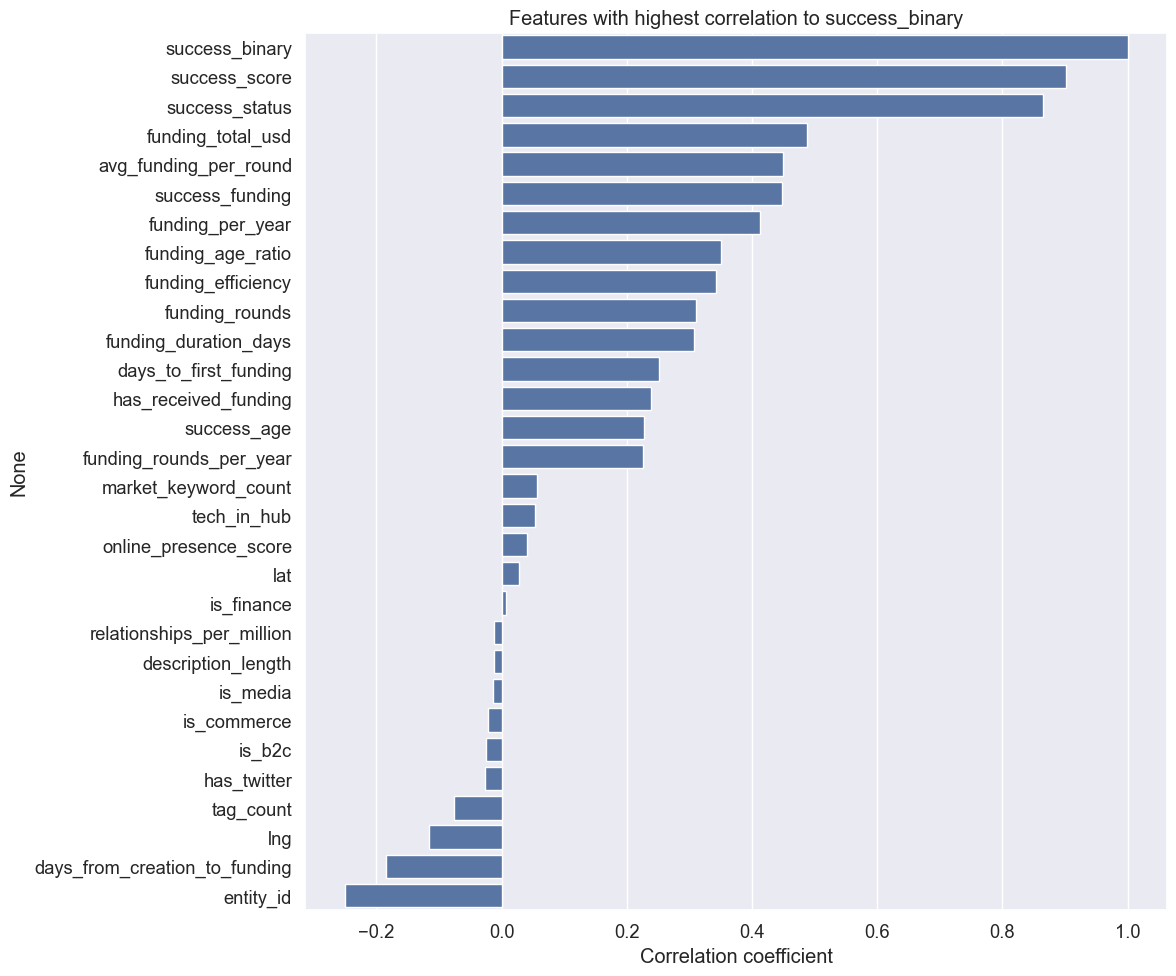

In [4]:
# Analyze correlations with the target variable
if target in corr_matrix.index:
    # Get correlations with the target
    target_correlations = corr_matrix[target].sort_values(ascending=False)

    # Display top positive correlations
    print("Top 15 features positively correlated with", target)
    print(target_correlations.head(15))

    # Display top negative correlations
    print("\nTop 15 features negatively correlated with", target)
    print(target_correlations.tail(15))

    # Plot correlation with target
    plt.figure(figsize=(12, 10))
    top_corr_features = pd.concat([target_correlations.head(15), target_correlations.tail(15)])
    sns.barplot(x=top_corr_features.values, y=top_corr_features.index)
    plt.title(f'Features with highest correlation to {target}')
    plt.xlabel('Correlation coefficient')
    plt.tight_layout()
    plt.savefig('target_correlation.png')
    plt.show()

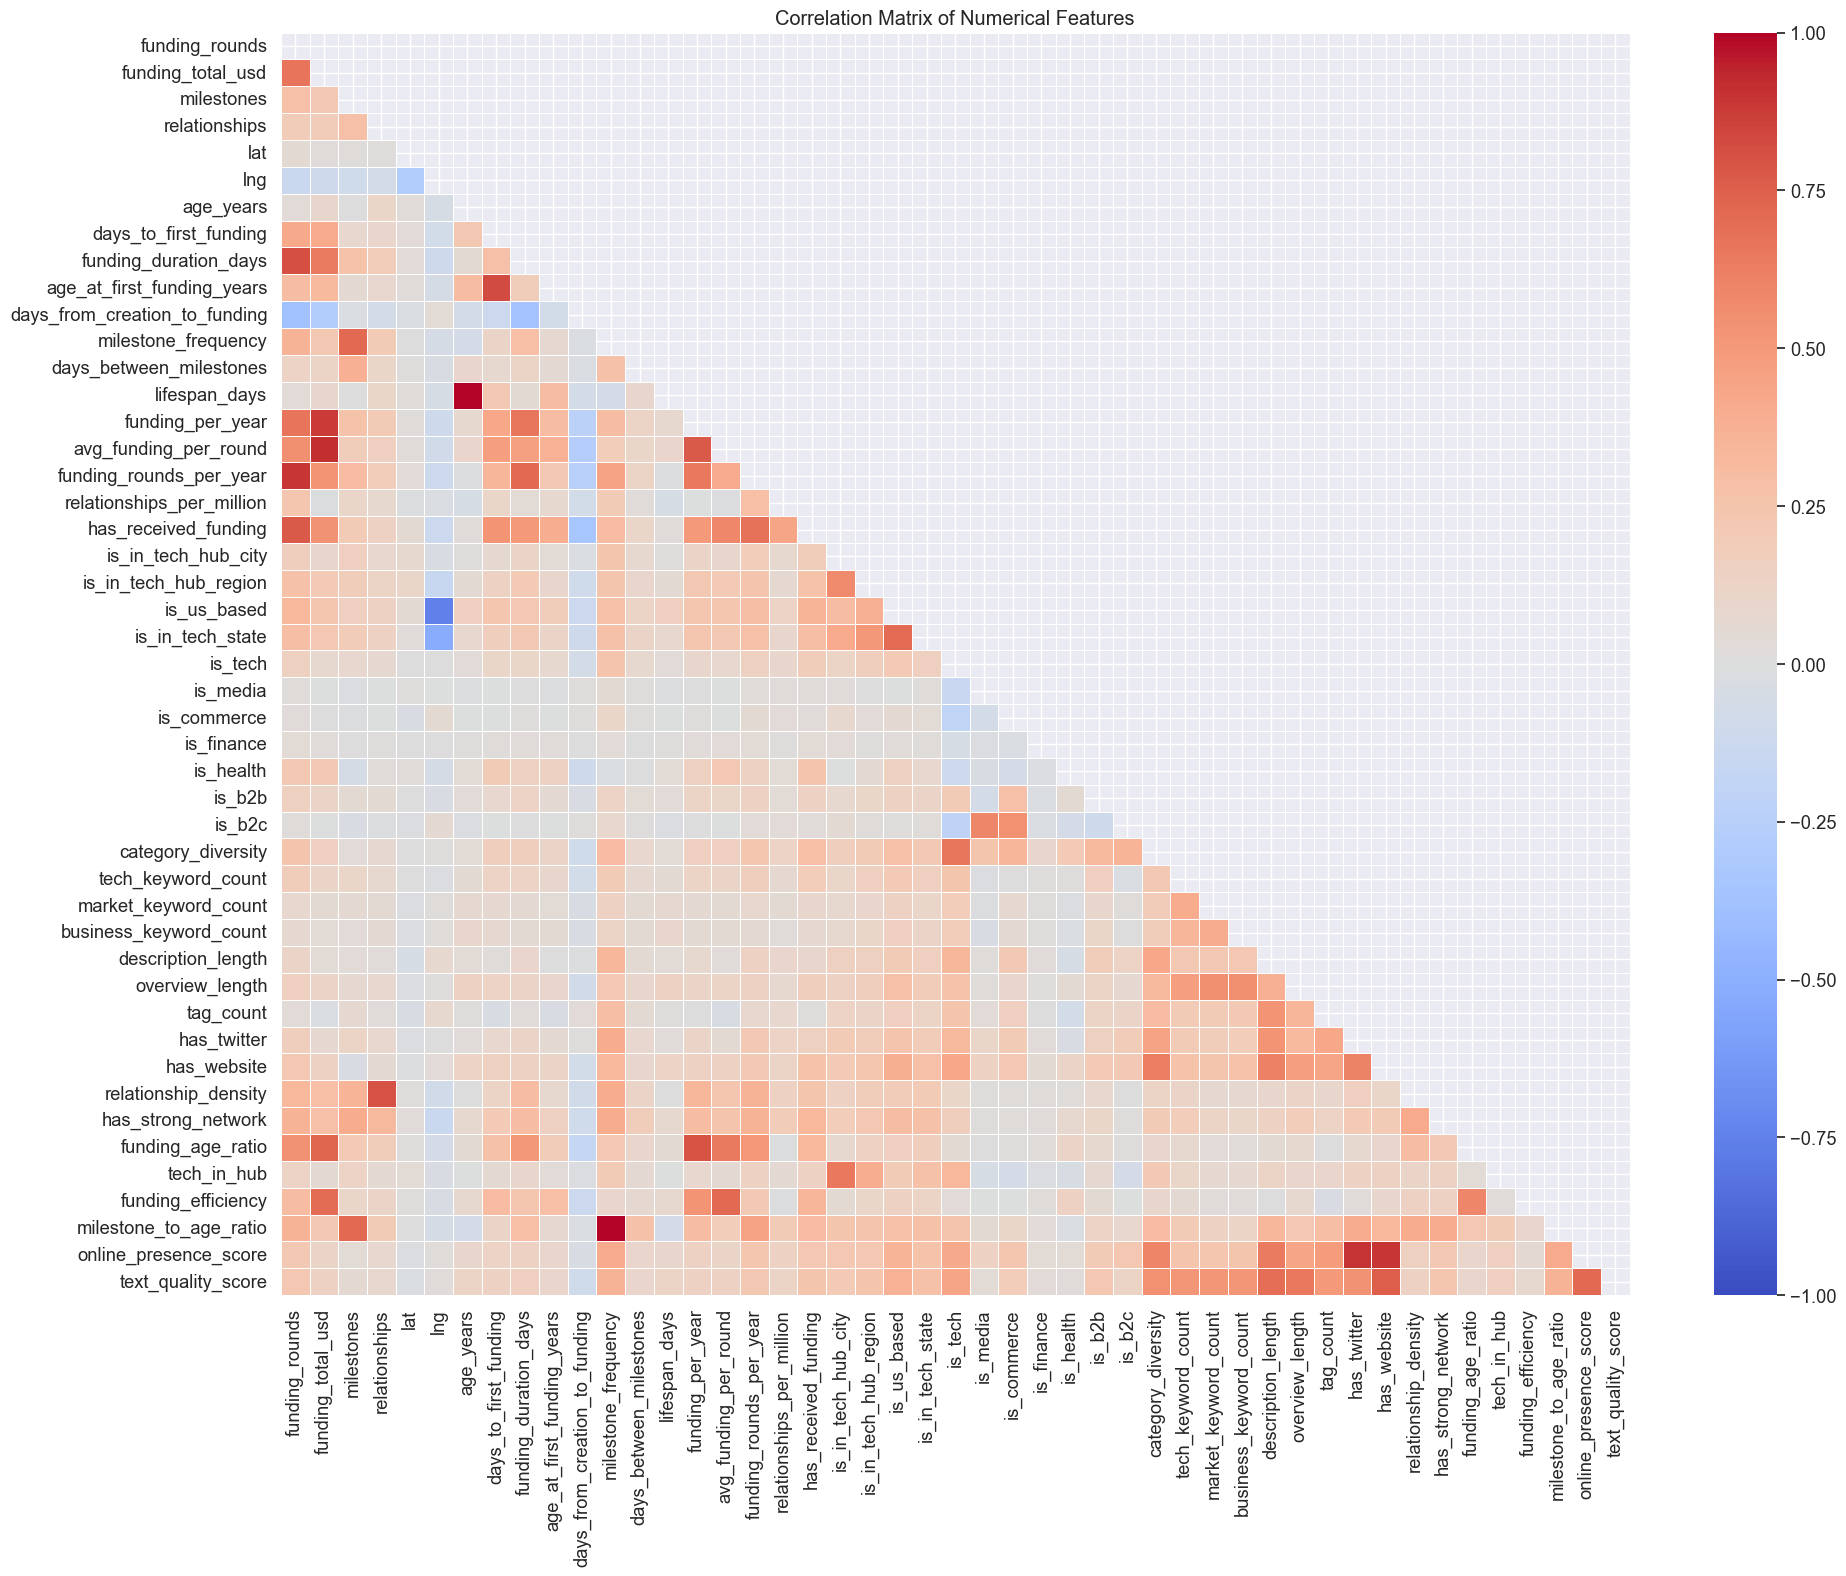

Found 9 highly correlated feature pairs (correlation > 0.8)
Features to remove due to multicollinearity: 9
{'lifespan_days', 'avg_funding_per_round', 'funding_per_year', 'funding_rounds_per_year', 'funding_duration_days', 'online_presence_score', 'has_twitter', 'milestone_frequency', 'age_at_first_funding_years'}


In [5]:
# Identify highly correlated features (multicollinearity)
plt.figure(figsize=(20, 16))
corr_subset = corr_matrix.loc[numerical_features, numerical_features]
mask = np.triu(np.ones_like(corr_subset, dtype=bool))
sns.heatmap(corr_subset, mask=mask, cmap='coolwarm', annot=False, 
            center=0, linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()

# Find highly correlated feature pairs
high_corr_threshold = 0.8
high_corr_features = set()
high_corr_pairs = []

for i in range(len(corr_subset.columns)):
    for j in range(i):
        if abs(corr_subset.iloc[i, j]) > high_corr_threshold:
            feat_i = corr_subset.columns[i]
            feat_j = corr_subset.columns[j]
            corr_val = corr_subset.iloc[i, j]
            high_corr_pairs.append((feat_i, feat_j, corr_val))

            # If both features have correlation with target, keep the one with higher correlation
            if target in corr_matrix.columns:
                corr_i = abs(corr_matrix.loc[feat_i, target]) if feat_i in corr_matrix.index else 0
                corr_j = abs(corr_matrix.loc[feat_j, target]) if feat_j in corr_matrix.index else 0

                if corr_i < corr_j:
                    high_corr_features.add(feat_i)
                else:
                    high_corr_features.add(feat_j)
            else:
                # If we don't have target correlation info, remove the second feature
                high_corr_features.add(feat_j)

print(f"Found {len(high_corr_pairs)} highly correlated feature pairs (correlation > {high_corr_threshold})")
print(f"Features to remove due to multicollinearity: {len(high_corr_features)}")
print(high_corr_features)

Running Random Forest for feature importance...
Top 20 features by Random Forest importance:
                          feature  importance
35                overview_length    0.084609
1               funding_total_usd    0.083715
43             funding_efficiency    0.054930
6                       age_years    0.049629
15          avg_funding_per_round    0.047553
5                             lng    0.046674
13                  lifespan_days    0.046573
41              funding_age_ratio    0.043445
4                             lat    0.043369
3                   relationships    0.041025
34             description_length    0.034641
14               funding_per_year    0.034583
36                      tag_count    0.028386
39           relationship_density    0.023980
46             text_quality_score    0.021037
10  days_from_creation_to_funding    0.018676
31             tech_keyword_count    0.018118
2                      milestones    0.017532
12        days_between_milestones

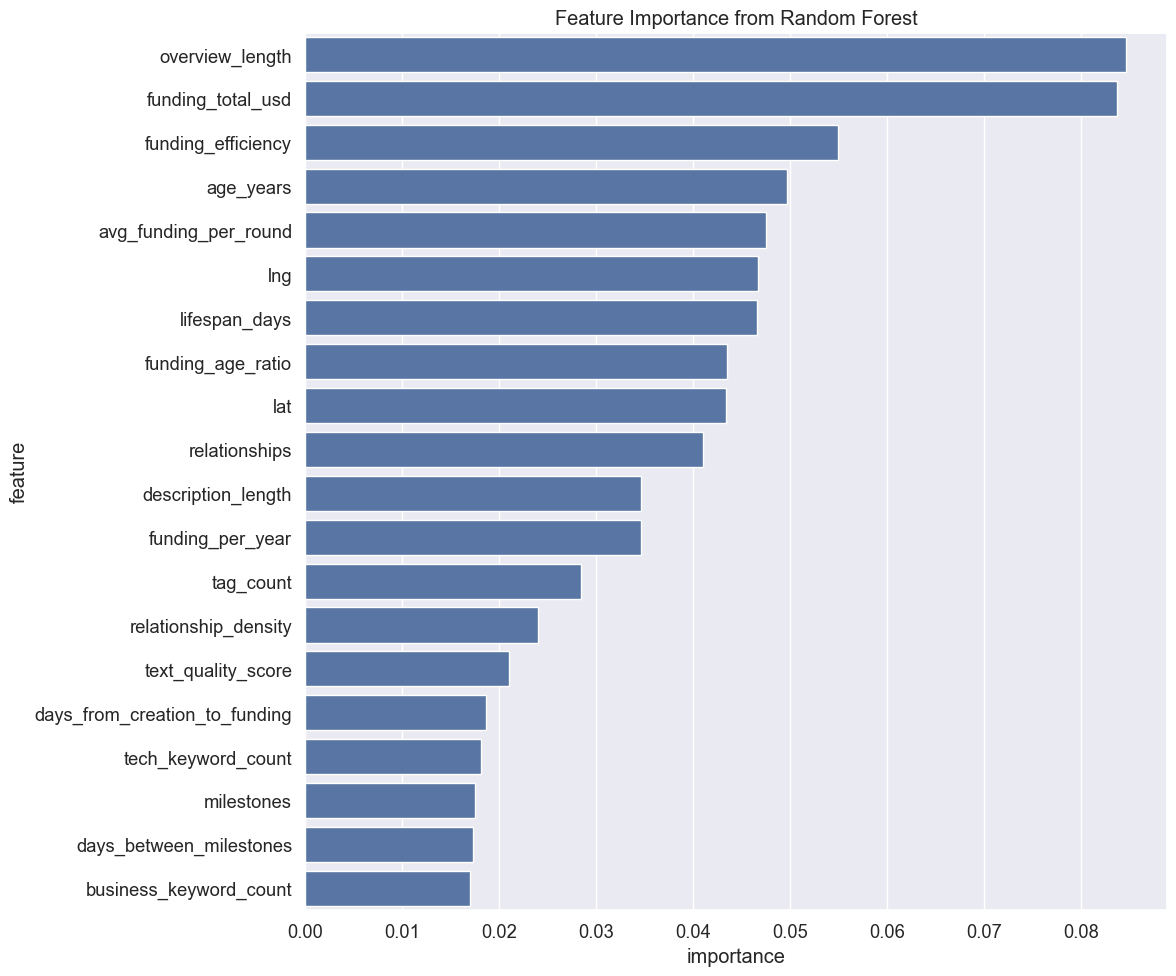

In [6]:
# Prepare data for feature importance analysis
# Handle missing values in numerical features
X_numerical = df[numerical_features].copy()
X_numerical = X_numerical.fillna(X_numerical.median())

# Get the target variable
y = df[target].copy()

# Feature selection using Random Forest feature importance
print("Running Random Forest for feature importance...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_numerical, y)

# Get feature importances
importances = pd.DataFrame({
    'feature': X_numerical.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

# Display top 20 important features
print("Top 20 features by Random Forest importance:")
print(importances.head(20))

# Plot feature importances
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=importances.head(20))
plt.title('Feature Importance from Random Forest')
plt.tight_layout()
plt.savefig('rf_feature_importance.png')
plt.show()

Running statistical feature selection using ANOVA F-value...
Top 20 features by ANOVA F-value:
                          feature         score  pvalue
1               funding_total_usd  61207.565645     0.0
15          avg_funding_per_round  49925.144281     0.0
14               funding_per_year  40379.257487     0.0
41              funding_age_ratio  27596.142859     0.0
43             funding_efficiency  26137.532821     0.0
0                  funding_rounds  20947.619574     0.0
8           funding_duration_days  20600.465484     0.0
7           days_to_first_funding  13184.685791     0.0
18           has_received_funding  11783.805143     0.0
16        funding_rounds_per_year  10593.065295     0.0
21                    is_us_based   9543.263930     0.0
9      age_at_first_funding_years   8411.402891     0.0
40             has_strong_network   8101.520555     0.0
10  days_from_creation_to_funding   6934.065739     0.0
22               is_in_tech_state   6793.797474     0.0
39       

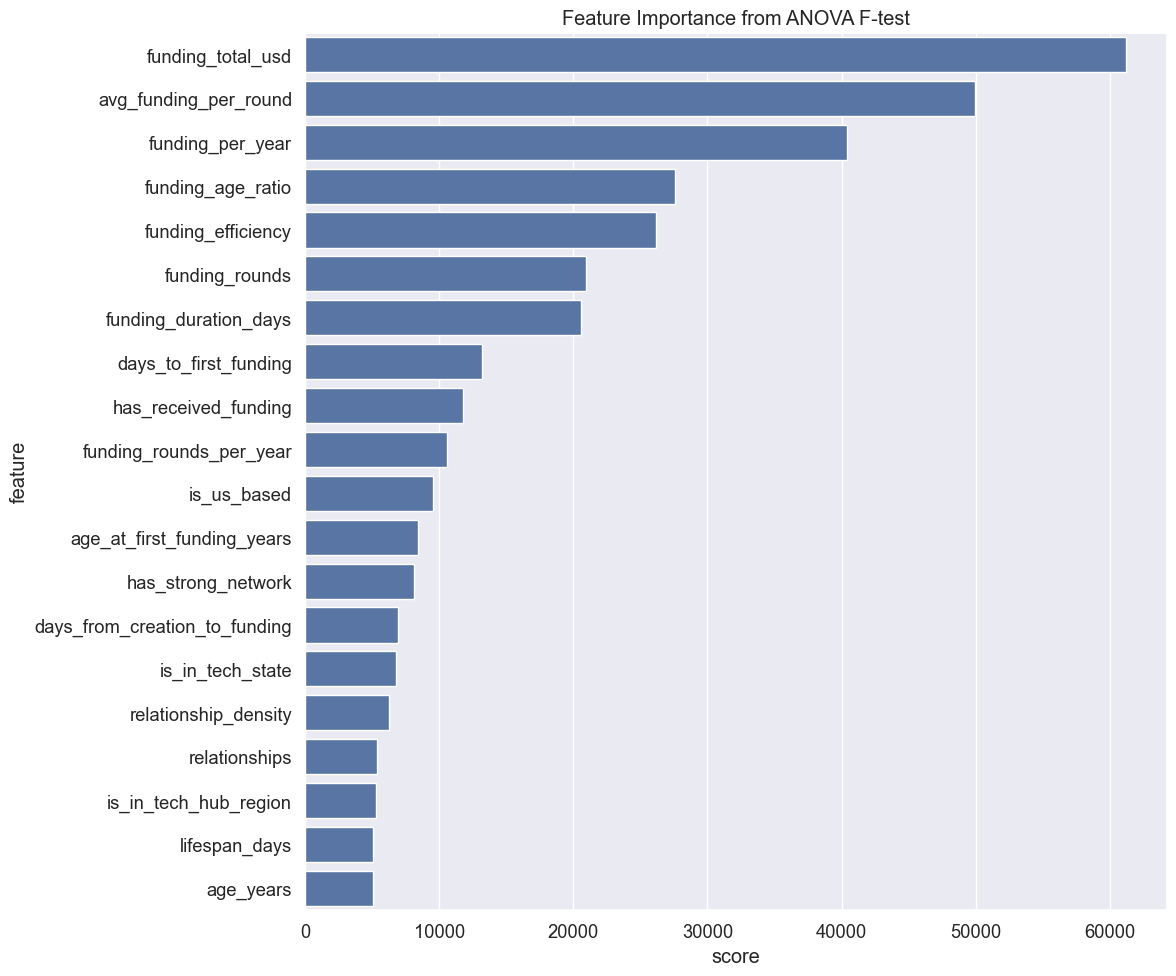

In [7]:
# Statistical feature selection using ANOVA F-value
print("Running statistical feature selection using ANOVA F-value...")
selector = SelectKBest(f_classif, k=20)
X_new = selector.fit_transform(X_numerical, y)

# Get selected feature names
mask = selector.get_support()
anova_selected_features = X_numerical.columns[mask].tolist()

# Get scores
anova_scores = pd.DataFrame({
    'feature': X_numerical.columns,
    'score': selector.scores_,
    'pvalue': selector.pvalues_
}).sort_values('score', ascending=False)

print("Top 20 features by ANOVA F-value:")
print(anova_scores.head(20))

# Plot ANOVA scores
plt.figure(figsize=(12, 10))
sns.barplot(x='score', y='feature', data=anova_scores.head(20))
plt.title('Feature Importance from ANOVA F-test')
plt.tight_layout()
plt.savefig('anova_feature_importance.png')
plt.show()

Running mutual information feature selection...
Top 20 features by Mutual Information:
                      feature     score
1           funding_total_usd  0.054842
43         funding_efficiency  0.051099
15      avg_funding_per_round  0.048153
6                   age_years  0.045308
41          funding_age_ratio  0.044407
5                         lng  0.042496
14           funding_per_year  0.041818
4                         lat  0.040258
38                has_website  0.039281
17  relationships_per_million  0.038489
13              lifespan_days  0.037086
39       relationship_density  0.035139
16    funding_rounds_per_year  0.031376
30         category_diversity  0.030768
3               relationships  0.030314
0              funding_rounds  0.028205
45      online_presence_score  0.027621
21                is_us_based  0.026319
44     milestone_to_age_ratio  0.025852
2                  milestones  0.025681


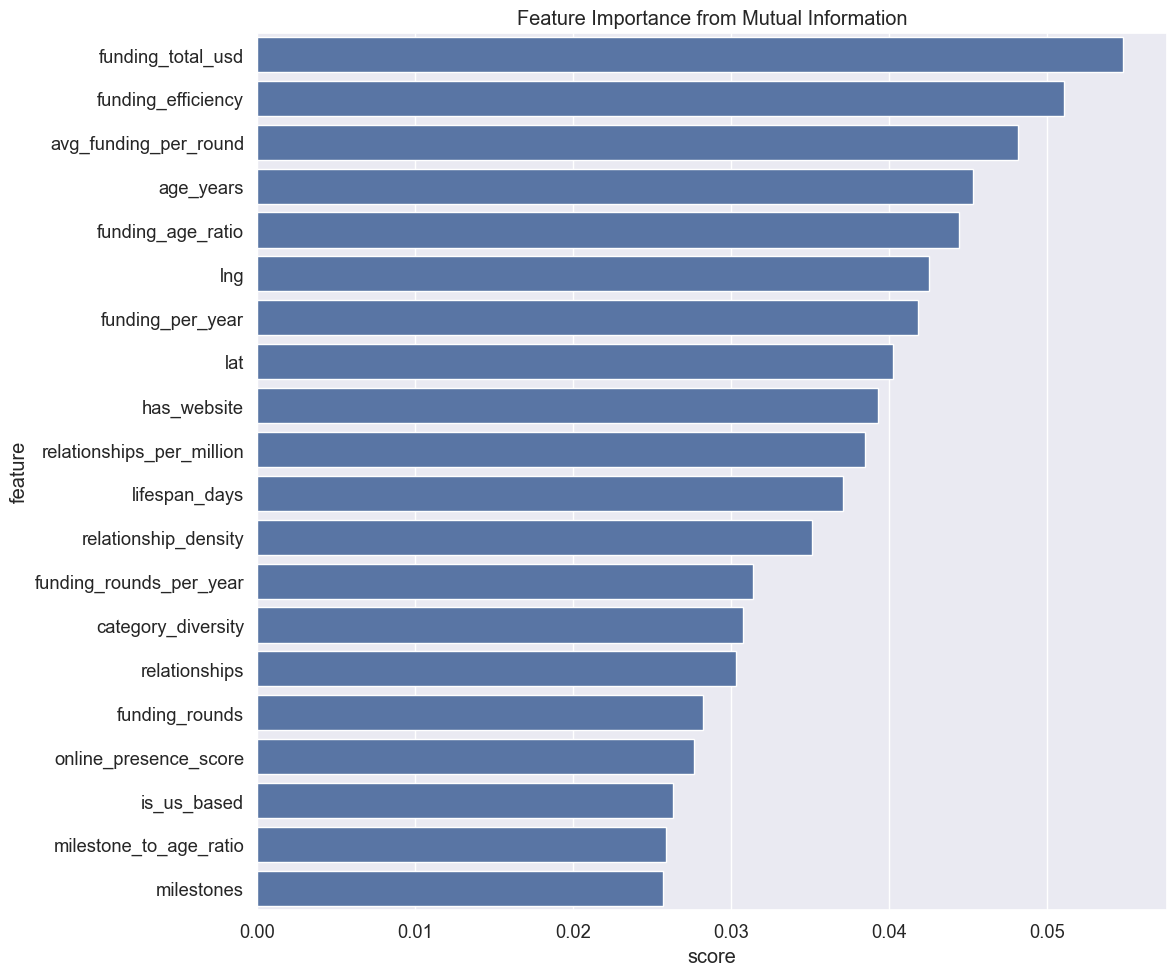

In [8]:
# Feature selection using mutual information (for non-linear relationships)
print("Running mutual information feature selection...")
selector_mi = SelectKBest(mutual_info_classif, k=20)
X_new_mi = selector_mi.fit_transform(X_numerical, y)

# Get selected feature names
mask_mi = selector_mi.get_support()
mi_selected_features = X_numerical.columns[mask_mi].tolist()

# Get scores
mi_scores = pd.DataFrame({
    'feature': X_numerical.columns,
    'score': selector_mi.scores_
}).sort_values('score', ascending=False)

print("Top 20 features by Mutual Information:")
print(mi_scores.head(20))

# Plot MI scores
plt.figure(figsize=(12, 10))
sns.barplot(x='score', y='feature', data=mi_scores.head(20))
plt.title('Feature Importance from Mutual Information')
plt.tight_layout()
plt.savefig('mi_feature_importance.png')
plt.show()

In [9]:
# Combine results from different methods to select final features
print("Combining results from different feature selection methods...")

# Correlation-based selection
if target in corr_matrix.columns:
    corr_threshold = 0.2
    corr_selected_features = [feat for feat in target_correlations.index 
                             if abs(target_correlations[feat]) > corr_threshold 
                             and feat != target 
                             and feat in numerical_features]
    print(f"Features selected by correlation (threshold={corr_threshold}): {len(corr_selected_features)}")
else:
    corr_selected_features = []
    print("No correlation data available for target")

# Get top 20 features from Random Forest
rf_selected_features = importances.head(20)['feature'].tolist()
print(f"Features selected by Random Forest: {len(rf_selected_features)}")

# Combine all selected features
all_selected_features = list(set(corr_selected_features + 
                                rf_selected_features + 
                                anova_selected_features + 
                                mi_selected_features))
print(f"Total unique features selected: {len(all_selected_features)}")

# Remove highly correlated features
final_features = [f for f in all_selected_features if f not in high_corr_features]
print(f"Final features after removing highly correlated ones: {len(final_features)}")

Combining results from different feature selection methods...
Features selected by correlation (threshold=0.2): 12
Features selected by Random Forest: 20
Total unique features selected: 35
Final features after removing highly correlated ones: 28


In [10]:
# Add important categorical features
# For categorical features, we'll include those that domain knowledge suggests are important
important_categorical = [
    'category_code', 'status', 'country_code', 'region_group',
    'is_in_tech_hub_city', 'is_in_tech_hub_region', 'is_us_based', 
    'is_in_tech_state', 'is_tech', 'is_media', 'is_commerce', 
    'is_finance', 'is_health', 'is_b2b', 'is_b2c',
    'has_twitter', 'has_website', 'has_strong_network',
    'has_received_funding', 'has_complete_core_info'
]

# Filter to only include categorical features that exist in the dataset
important_categorical = [f for f in important_categorical if f in df.columns]
print(f"Important categorical features to include: {len(important_categorical)}")

# Add categorical features to final feature list
final_features_with_categorical = final_features + important_categorical
print(f"Final feature count including categorical: {len(final_features_with_categorical)}")

Important categorical features to include: 20
Final feature count including categorical: 48


In [11]:
# Create final dataset with selected features
print("Creating final dataset with selected features...")
final_df = df[final_features_with_categorical + target_vars].copy()
print(f"Final dataset shape: {final_df.shape}")

# Save the final dataset
final_df.to_csv('selected_features.csv', index=False)
print("Saved selected features to 'selected_features.csv'")

Creating final dataset with selected features...
Final dataset shape: (196553, 55)
Saved selected features to 'selected_features.csv'


In [12]:
# Create feature importance summary
print("Creating feature importance summary...")

# Combine importance scores from different methods
feature_importance_df = pd.DataFrame({'feature': final_features})

# Add correlation scores if available
if target in corr_matrix.columns:
    feature_importance_df['correlation'] = feature_importance_df['feature'].apply(
        lambda x: corr_matrix.loc[x, target] if x in corr_matrix.index else 0
    )
else:
    feature_importance_df['correlation'] = 0

# Add Random Forest importance
feature_importance_df['rf_importance'] = feature_importance_df['feature'].apply(
    lambda x: importances.loc[importances['feature'] == x, 'importance'].values[0] 
    if x in importances['feature'].values else 0
)

# Add ANOVA scores
feature_importance_df['anova_score'] = feature_importance_df['feature'].apply(
    lambda x: anova_scores.loc[anova_scores['feature'] == x, 'score'].values[0] 
    if x in anova_scores['feature'].values else 0
)

# Add Mutual Information scores
feature_importance_df['mi_score'] = feature_importance_df['feature'].apply(
    lambda x: mi_scores.loc[mi_scores['feature'] == x, 'score'].values[0] 
    if x in mi_scores['feature'].values else 0
)

# Calculate composite score (normalized sum of all methods)
for col in ['correlation', 'rf_importance', 'anova_score', 'mi_score']:
    if feature_importance_df[col].max() > 0:
        feature_importance_df[f'{col}_norm'] = feature_importance_df[col] / feature_importance_df[col].max()
    else:
        feature_importance_df[f'{col}_norm'] = 0

feature_importance_df['composite_score'] = (
    feature_importance_df['correlation_norm'] + 
    feature_importance_df['rf_importance_norm'] + 
    feature_importance_df['anova_score_norm'] + 
    feature_importance_df['mi_score_norm']
)

# Sort by composite score
feature_importance_df = feature_importance_df.sort_values('composite_score', ascending=False)

# Add categorical features with NaN for numerical scores
categorical_importance_df = pd.DataFrame({'feature': important_categorical})
for col in feature_importance_df.columns:
    if col != 'feature':
        categorical_importance_df[col] = np.nan

# Combine numerical and categorical features
all_importance_df = pd.concat([feature_importance_df, categorical_importance_df], ignore_index=True)

# Save feature importance information
all_importance_df.to_csv('feature_importance.csv', index=False)
print("Saved feature importance to 'feature_importance.csv'")

Creating feature importance summary...
Saved feature importance to 'feature_importance.csv'


In [13]:
# Generate a feature selection report
print("Generating feature selection report...")

# Top features by each method
top_by_correlation = feature_importance_df.sort_values('correlation', ascending=False).head(10)['feature'].tolist() if 'correlation' in feature_importance_df.columns else []
top_by_rf = feature_importance_df.sort_values('rf_importance', ascending=False).head(10)['feature'].tolist()
top_by_anova = feature_importance_df.sort_values('anova_score', ascending=False).head(10)['feature'].tolist()
top_by_mi = feature_importance_df.sort_values('mi_score', ascending=False).head(10)['feature'].tolist()

# Create report
report = f"""
# Feature Selection Report

## Summary
- Total features in original dataset: {len(df.columns)}
- Numerical features analyzed: {len(numerical_features)}
- Categorical features included: {len(important_categorical)}
- Features removed due to multicollinearity: {len(high_corr_features)}
- Final features selected: {len(final_features_with_categorical)}

## Top Features by Method

### Top 10 by Correlation with {target}
{', '.join(top_by_correlation)}

### Top 10 by Random Forest Importance
{', '.join(top_by_rf)}

### Top 10 by ANOVA F-value
{', '.join(top_by_anova)}

### Top 10 by Mutual Information
{', '.join(top_by_mi)}

## Highly Correlated Feature Pairs Removed
The following feature pairs had correlation coefficients above {high_corr_threshold}:
"""

for feat1, feat2, corr in high_corr_pairs:
    report += f"- {feat1} and {feat2}: {corr:.3f}\n"

# Write report to file
with open('feature_selection_report.md', 'w') as f:
    f.write(report)

print("Feature selection complete!")
print("Generated files:")
print("1. selected_features.csv - Dataset with selected features")
print("2. feature_importance.csv - Feature importance rankings")
print("3. feature_selection_report.md - Detailed report")
print("4. Various visualization files (.png)")

Generating feature selection report...
Feature selection complete!
Generated files:
1. selected_features.csv - Dataset with selected features
2. feature_importance.csv - Feature importance rankings
3. feature_selection_report.md - Detailed report
4. Various visualization files (.png)
